In [1]:
import torch,torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import *
from torch.optim import *

In [2]:
data = pd.read_csv('btcNewsToPrice2.csv')

In [3]:
data.head()

,date,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,...,top_32,top_33,top_34,top_35,price,open,high,low,vol.,change %
0,2015-07-12,bitcoin the next logical step in the rise of u...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,310.4,292.0,315.9,291.3,120.70K,6.33%
1,2015-07-13,bitgive foundation announces new initiatives a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,290.4,310.4,310.9,276.9,146.85K,-6.47%
2,2015-07-14,keynote 2015 harnessing the distributed ledge...,the blockchain towards crypto sovereignty ...,coinbase outage is a reminder to not store bit...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,287.0,290.4,297.0,285.2,60.62K,-1.17%
3,2015-07-15,patrick byrne says will be able to replace w...,bitcoin in review interesting trends in q1 of...,cloudminr user accounts hacked data sold for ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,283.4,287.0,292.9,283.2,59.58K,-1.23%
4,2015-07-16,2015 q1 bitcoin investment trumps 2014 numbers...,cash back vs bitcoin why bitcoin can be super...,force or mathematics fiat vs cryptocurrency ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,276.6,283.4,290.8,273.3,121.32K,-2.41%


In [4]:
X = data['date'].tolist()

In [5]:
new_X = []

In [6]:
for x in X:
    x = x.split('-')
    x = int(f'{x[0]}{x[1]}{x[2]}')
    new_X.append(x)

In [7]:
X = new_X

In [8]:
X = torch.from_numpy(np.array(new_X))

In [9]:
y = torch.from_numpy(np.array(data['high'].tolist()))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.125,shuffle=False)

In [12]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([1877]), torch.Size([269]), torch.Size([1877]), torch.Size([269]))

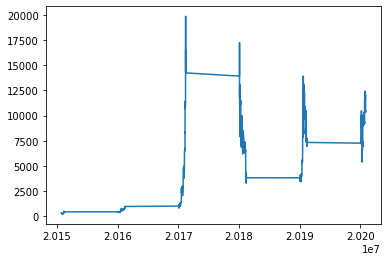

In [13]:
plt.figure()
plt.plot(X_train,y_train)
plt.show()

In [14]:
class LSTMPredictor(Module):
    def __init__(self,n_hidden=512):
        super().__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = LSTMCell(1,self.n_hidden)
        self.lstm2 = LSTMCell(self.n_hidden,self.n_hidden)
        self.linear = Linear(self.n_hidden,1)
    
    def forward(self,X,future=0):
        outputs = []
        n_samples = X.size(0)
        h_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        h_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        for input_t in X.split(1,dim=1):
            h_t,c_t = self.lstm1(input_t,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        for i in range(future):
            h_t,c_t = self.lstm1(output,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=1)
        return outputs

In [15]:
device = 'cpu'

In [16]:
model = LSTMPredictor().to(device)

In [17]:
epochs = 100

In [18]:
batch_size = len(X_train)

In [19]:
from tqdm import tqdm
import wandb
PROJECT_NAME = 'Bitcoin-Price-Prediction'

In [20]:
criterion = MSELoss()
optimizer = Adam(model.parameters(),lr=0.001)

In [21]:
import cv2

In [22]:
y_train = y_train.view(1,-1).to(device).float()
y_test = y_test.view(1,-1).to(device).float()

In [ ]:
wandb.init(project=PROJECT_NAME,name='baseline')
for _ in tqdm(range(epochs)):
    model.to(device)
    preds = model(y_train[:3,:-1].float())
    preds.to(device)
    loss = criterion(preds,y_train[:3,1:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    wandb.log({'Loss':loss.item()})
    with torch.no_grad():
        future = 100
        pred = model(y_test.view(1,-1)[:3,:-1].float(),future=future)
        loss = criterion(pred[:,:-future],y_test.view(1,-1).float()[:3,1:])
        y = pred.detach().numpy()
        wandb.log({'Val Loss':loss.item()})
    plt.figure(figsize=(12,6))
    plt.title(f'Step')
    n = y_test.view(1,-1)[:3,:-1].float().shape[1]
    def draw(y_i,color):
        plt.plot(np.arange(n),y_test.view(1,-1).float()[:3,1:][:n].view(-1),color)
        plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
    draw(y[0],'r')
    plt.savefig('./preds/img.png')
    plt.close()
    wandb.log({'Val Img':wandb.Image(cv2.imread('./preds/img.png'))})
    
    with torch.no_grad():
        future = 100
        pred = model(y_train.view(1,-1)[:3,:-1].float(),future=future)
        loss = criterion(pred[:,:-future],y_train.view(1,-1).float()[:3,1:])
        y = pred.detach().numpy()
        wandb.log({'Val Loss':loss.item()})
    plt.figure(figsize=(12,6))
    plt.title(f'Step')
    n = y_train.view(1,-1)[:3,:-1].float().shape[1]
    def draw(y_i,color):
        plt.plot(np.arange(n),y_train.view(1,-1).float()[:3,1:][:n].view(-1),color)
        plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
    draw(y[0],'r')
    plt.savefig('./preds/img.png')
    plt.close()
    wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})
wandb.finish()

In [ ]:
y

In [ ]:
y_test.view(1,-1).float()[:3,1:][:n].view(-1)

In [ ]:
y_train[:3,:-1]

In [ ]:
preds